In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

exclude_pids = [
    "65e5e9c2c0bfcbcbe835ec4d",
    "60fd64fd34ee5940500d499f",
    "61679f24fb77ff4978222991",
    "63fceba525d21052bc1ee390",
    "6526246367b37eef371ba914",
    "65798ffea5411209c86f31df",
    "65c630cc3824e0cf64dd2f7a",
    "615251a465f058e211cfbbb8",
    "5b197b8088ee7400012ae154",
    "5bad4db8b712f30001b87990",
    "5e6fd38fe95be7071b5196bf",
    "5fd79aba1833640f79ffd07d",
    "603421c858a3bd213d7c24b2",
    "604011377e5b121dc3267a3e",
    "60933bb6e47eb28c880b93d9",
    "613ad21e63b6c74708c223a9",
    "63bed6e176fba857a47fbaff",
    "63d54c4128bf8c671033ade4",
    "652da7c42cac6d10ff9de007",
    "65a6900704afb0a6f2f893d4",
    "65ba2af02a6a7f08d9e2b6c2",
    "660b812f113edc37de1df2b3",
    "6633381060353bc96809fc95",
    "660c87ac0012e87d84862040",
    "6414be45ec452483d7579868",
    "654e5bcb8cb6aeb8ca9b33a0",
    "661939712ce7ac67b60ab773",
    "5e2380c152e7a66358a276c5",
    "65086209d6edf5f2cf5f05d4",
    "6138df3f784ed068ae002cb3",
    "5d5035c5d87393001af70561",
    "614fe09fec9ce4a2a415476d",
    "5dd6dadf9c84d86703aa8615",
    "64528f4d51f889c0c30573af",
    "57ab3f8321e5a50001562cd3",
    "5ff39ec71d6cb49c6c906727",
    "603000ac19eaccdcf8b92e62",
    "61215755cea9b916eef0a38b"
]

In [2]:
def fix_lng_cols(text):
    if type(text) == float:
        return 'NONE'
        
    text = text.strip().lower()
    text = text.replace('language', '')
    text = text.strip()
    if text in ['english', 'enlgish', 'englis', 'eng']:
        return 'ENG'
    if text in ['spanish']:
        return 'ES'
    if 'eng' in text and 'spa' in text:
        return 'BOTH'
    if text in ['portuguese']:
        return 'NONE'
    else:
        return 'NONE'


def get_lng_proficiency(lng: str, df_copy):
    # either 'native' or 'second'
    self_rate_categories = ['Reading', 'Writing', 'Speaking', 'Listening']
    self_rate_base = f'How would you rate your fluency in your {lng} language, for each of these categories:'
    
    self_usage_categories = ['At work', 'At home',
                             'Interacting with friends',
                             'Interacting with family',
                             'Entertainment (TV series, music, etc.)']
    self_usage_base = f'Please rate how likely you are to use your {lng} language in the following contexts:'
    
    self_rate_questions = [f'{self_rate_base} {c}' for c in self_rate_categories]
    self_usage_questions = [f'{self_usage_base} {c}' for c in self_usage_categories]
    
    questions = self_rate_questions + self_usage_questions
    return df_copy[questions].mean(axis=1).copy()
    
def fix_lng_data(df):
    df['lng_1'] = df['Enter your native language, or the language you are providing answers for, here:'].apply(fix_lng_cols)
    df['lng_2'] = df['Enter your most proficient second language here:'].apply(fix_lng_cols)

    self_rate_categories = ['Reading', 'Writing', 'Speaking', 'Listening']
    lng1_self_rate_base = 'How would you rate your fluency in your native language, for each of these categories:'
    lng1_self_rate_questions = [f'{lng1_self_rate_base} {c}' for c in self_rate_categories]
    
    lng1_prof_list = get_lng_proficiency('native', df)
    df = df.assign(lng1_prof=lng1_prof_list)
    
    lng2_prof_list = get_lng_proficiency('second', df)
    df = df.assign(lng2_prof=lng2_prof_list)

    
    eng_prof = []
    spa_prof = []

    for i, (lng1, lng2, lng1_p, lng2_p) in df[['lng_1', 'lng_2', 'lng1_prof', 'lng2_prof']].iterrows():
        if lng1 == 'ENG' and lng2 == 'ES':
            eng_prof.append(lng1_p)
            spa_prof.append(lng2_p)
        elif lng1 == 'ES' and lng2 == 'ENG':
            eng_prof.append(lng2_p)
            spa_prof.append(lng1_p)
        elif lng1 == 'BOTH':
            eng_prof.append(lng1_p)
            spa_prof.append(lng1_p)   
        elif lng2 == 'BOTH':
            eng_prof.append(lng2_p)
            spa_prof.append(lng2_p) 
        #edge cases...
        elif lng1 == lng2 == 'ENG':
            eng_prof.append(lng1_p)
            spa_prof.append(None) 
        elif lng1 == lng2 == 'ES':
            spa_prof.append(lng1_p)
            eng_prof.append(None) 
        elif lng1 == lng2 == 'NONE':
            spa_prof.append(None)
            eng_prof.append(None) 
        elif lng1 == 'NONE' and lng2 == 'ENG':
            eng_prof.append(lng2_p)
            spa_prof.append(None) 
        elif lng1 == 'NONE' and lng2 == 'ES':
            eng_prof.append(None)
            spa_prof.append(lng2_p)
        elif lng2 == 'NONE' and lng1 == 'ENG':
            eng_prof.append(lng1_p)
            spa_prof.append(None) 
        elif lng2 == 'NONE' and lng1 == 'ES':
            eng_prof.append(None)
            spa_prof.append(lng1_p) 
        else:
            print(lng1, lng1_p)
            print(lng2, lng2_p)
            print()
    
    print('lng prof validation', len(eng_prof) == len(df))
    df = df.assign(eng_prof=eng_prof)
    df = df.assign(spa_prof=spa_prof)
    return df

df = pd.read_csv('raw_experiments.csv', index_col=0)
print(df.shape)
df = fix_lng_data(df)
print(df.shape)

df.to_csv('experiments_w_lng_data.csv')

(1300, 133)
lng prof validation True
(1300, 139)


In [3]:
df = df[~df.pid.isin(exclude_pids)]
print(len(df))
for col in df.columns:
    print(col)

1236
experiment
human_role
map
pid
game_time
is_time_success
user number of utterances
user mean utterance length
user total number of tokens
user number of eng utterances
user number of es utterances
user number of mix utterances
user number of none utterances
user number of inter-sentential cs
user number of utterances with some ins switch
user number of total ins switches
user number of cong_masc switches
user number of cong_fem switches
user number of incong_masc switches
user number of incong_fem switches
user number of NP switches
user number of amb_masc switches
user number of amb_fem switches
user number of masc det switches
user number of fem det switches
user % entrainment - all dialog
user % entrainment - on bot inter-sentential cs
user number of cong_masc aligned to bot
user number of cong_fem aligned to bot
user number of incong_masc aligned to bot
user number of incong_fem aligned to bot
user number of NP aligned to bot
user number of amb_masc aligned to bot
user number o

In [4]:
alt_experiments = ['Alternation Baseline', 'Alternation Random CS', 'Alternation Short-context CS',
                   'Alternation Alignment CS', 'Alternation Adversarial CS']
ins_experiments = ['Insertional Spanish Baseline', 'Insertional Spanish Congruent','Insertional Spanish Masculine InCongruent',
                   'Insertional Spanish Feminine InCongruent']
global_exp_ =  'ins' #'ins' # 'alt'


experiments = ins_experiments if global_exp_ == 'ins' else alt_experiments
role = 'all' #'all' #'instructor' #'navigator'


In [5]:
def get_experiment_df(exp: list[str]):
    new_df = df[df['experiment'].isin(exp)]
    if role == 'all':
        return new_df
    return new_df[new_df['human_role'] == role]



def remove_rename_columns(df, remove=True):
    questions_rename = {'How much did you enjoy the task?' : 'Q_enjoy',
                        "How successful do you think you were at completing the task?" : 'Q_successful',
                        "How likely would you be to mix languages in the following contexts? Interacting with friends": "Q_mix_friends",
                        'Do you enjoy mixing languages in conversation?': "Q_enjoy_mix",
                        "How natural was your conversational partner’s language switching?": "Q_natural",
                        "On a day-to-day basis, how likely are you to have a conversation using both English and Spanish?": "Q_mix_often"
                       }
    if remove:
        remove_cols = ['human_role', 'experiment', 'map', 'pid']
        all_cols = list(df.columns)
        remove_cols.extend(list(filter(lambda x: 'bot_' in x, all_cols)))
        df = df.drop(remove_cols, axis=1)
    
    df = df.rename(columns=questions_rename, errors="raise")
    
    df["English %"] = df["user number of eng utterances"] / df["user number of utterances"] *100 
    df["None %"] = df["user number of none utterances"] / df["user number of utterances"] *100 
    df["Spanish %"] = df["user number of es utterances"] / df["user number of utterances"]  *100
    df["Mix %"] = df["user number of mix utterances"] / df["user number of utterances"]  *100
    
    df["Inter-Sentential CS %"] = df["user number of inter-sentential cs"] / (df["user number of utterances"] - 1)  *100

    df['% entrainment - on bot inter-sentential cs'] = df['user % entrainment - on bot inter-sentential cs'] * 100
    df['% entrainment - all dialog'] = df['user % entrainment - all dialog'] * 100

    # remove custom na
    if global_exp_ == 'ins':
        df = df.drop(df.loc[df['Q_natural'] == 'na'].index)
        df = df.drop(df.loc[df['Q_mix_often'] == 'na'].index)

    df = df.drop(df.loc[df['Q_mix_friends'] == 'na'].index)
    df = df.drop(df.loc[df['Q_enjoy_mix'] == 'na'].index)


    df['Q_mix_friends'] = df['Q_mix_friends'].astype(int)
    df['Q_enjoy_mix'] = df['Q_enjoy_mix'].astype(int)

    if global_exp_ == 'ins':
        df['Q_natural'] = df['Q_natural'].astype(int)
        df['Q_mix_often'] = df['Q_mix_often'].astype(int)


    return df

In [6]:
def plot_corr_matt(df, title):
    f = plt.figure(figsize=(15, 15))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(f'{title} - Correlation Matrix', fontsize=16)

    
def plot_2d_scatter(df, title, x, y, color, size):
    print(df.shape)
    fig = px.scatter(df, x=x, y=y, color=color, size=size, title=title)
    fig.show()

In [7]:
df_copy = get_experiment_df(experiments)
df_copy = remove_rename_columns(df_copy, False)
print(df_copy.shape)

(628, 146)


Filter switchers?

In [8]:
# df_copy = df_copy[df_copy['Q_mix_often'] >= 50]
# df_copy = df_copy[df_copy['Mix %'] > 0]
# df_copy.shape

user number of incong_fem switches - 40 participants, 54 chats, 85 switches
human_role
instructor    44
navigator     10
Name: count, dtype: int64


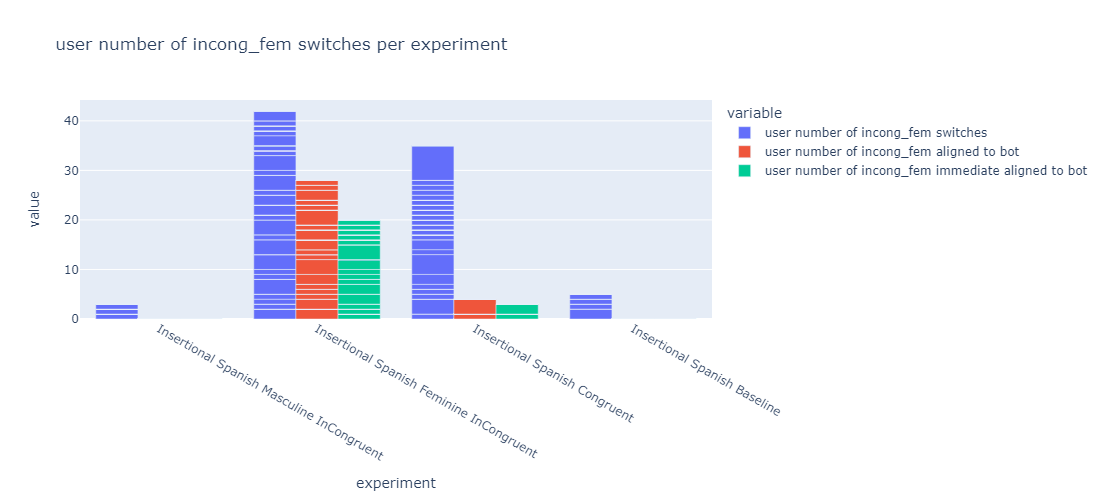

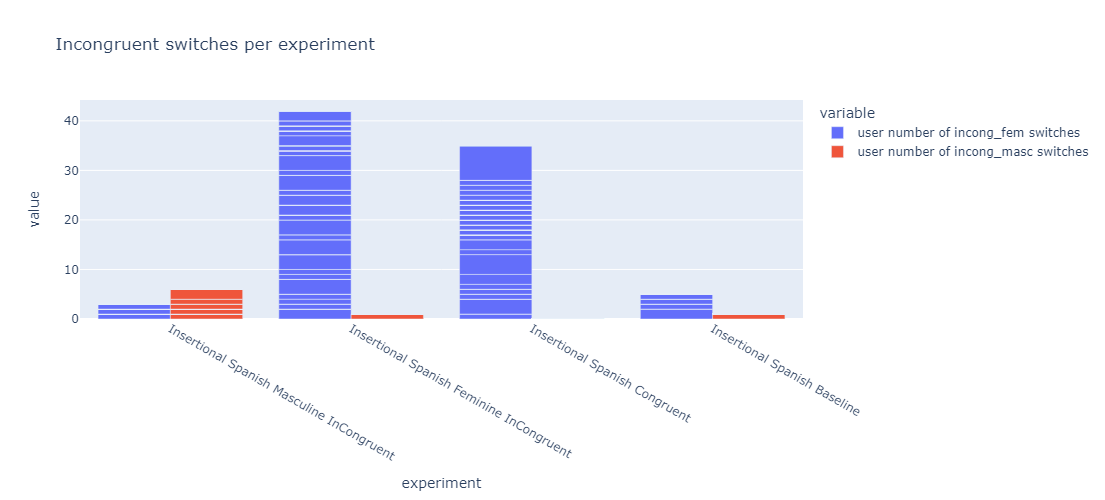

In [27]:

switch = 'incong_fem' #'incong_fem'
y_ = f'user number of {switch} switches'
ent1_y = f'user number of {switch} aligned to bot'
ent2_y = f'user number of {switch} immediate aligned to bot'

df_test = df_copy[df_copy[y_] > 0]
num_chats = df_test.shape[0]
num_partcipiants = len(df_test['pid'].unique())
num_swtiches = sum(df_test[y_])
print(f'{y_} - {num_partcipiants} participants, {num_chats} chats, {num_swtiches} switches')
print(df_test['human_role'].value_counts())

fig = px.bar(df_copy,
             x='experiment',
             y=[y_, ent1_y, ent2_y],
             barmode = 'group',
             orientation = "v",
             title=f"{y_} per experiment",
             width=800, height=500
            ).show()



fig = px.bar(df_copy,
             x='experiment',
             y=['user number of incong_fem switches', 'user number of incong_masc switches'],
             barmode = 'group',
             orientation = "v",
             title=f"Incongruent switches per experiment",
             width=800, height=500
            ).show()

In [10]:
# df_test[[ent1_y, y_,'experiment', 'pid']]

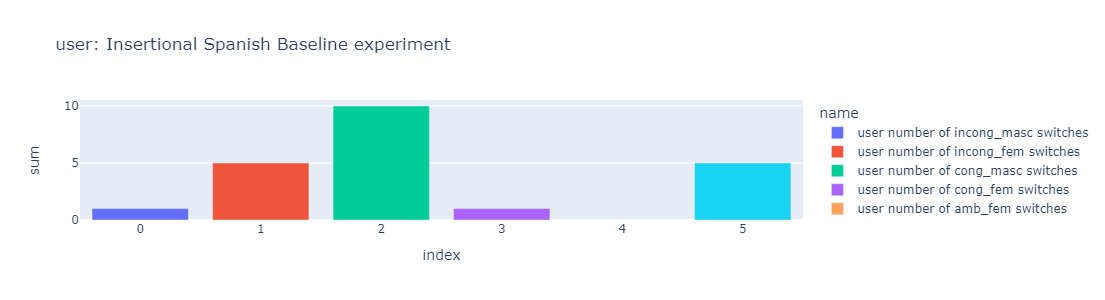

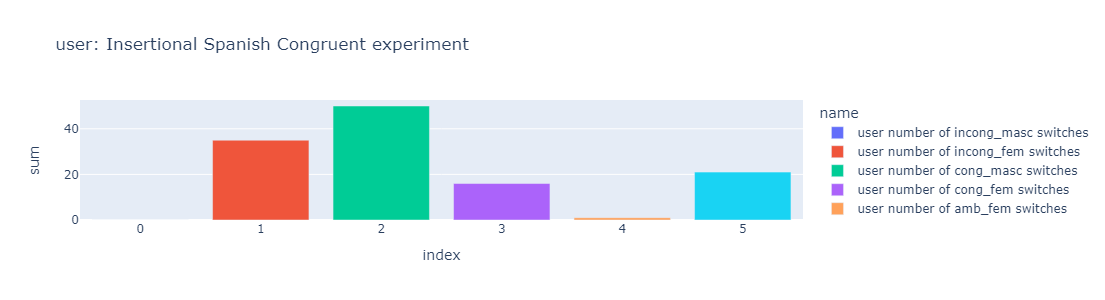

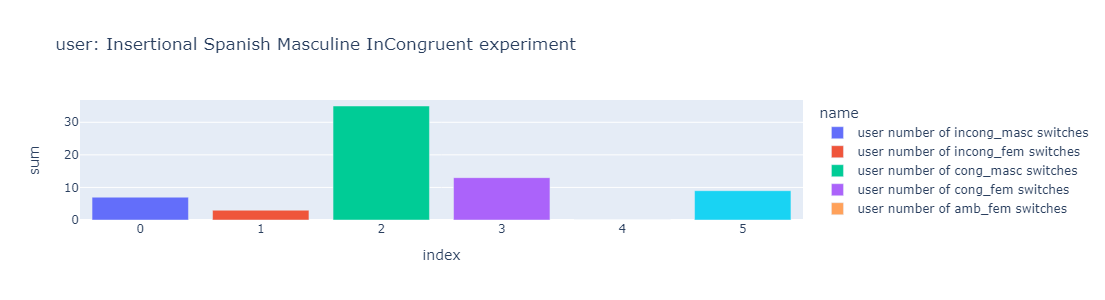

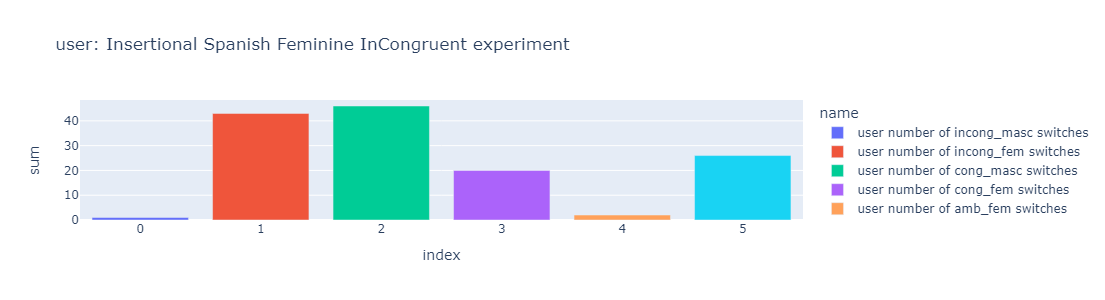

In [11]:
speaker = 'user' #'user
for exp in experiments:
    exp_df = get_experiment_df([exp])

    features = [
                f'{speaker} number of incong_masc switches',
                f'{speaker} number of incong_fem switches', 
                f'{speaker} number of cong_masc switches',
                f'{speaker} number of cong_fem switches',
                f'{speaker} number of amb_fem switches',
                f'{speaker} number of amb_masc switches'
                 ]
    sums_ = []
    for f in features:
        sums_.append(sum(exp_df[f]))
    
    tmp_df = pd.DataFrame.from_dict({'sum':sums_, 'name':features})
    fig = px.bar(tmp_df,
                 y='sum',
                 color='name',
                 title=f"{speaker}: {exp} experiment",
                 width=600, height=300).show()


In [12]:
# exp_idx = 3
# print(experiments[exp_idx])
# exp_df = get_experiment_df([experiments[exp_idx]])
# print(len(exp_df))

# y_ = f'{speaker} number of incong_masc switches'

# df_test = exp_df[exp_df[y_] > 0]

# num_chats = df_test.shape[0]
# num_partcipiants = len(df_test['pid'].unique())
# num_swtiches = sum(df_test[y_])
# print(f'{y_} - {num_partcipiants} participants, {num_chats} chats, {num_swtiches} switches')
# print(df_test['human_role'].value_counts())

# df_test

In [13]:
# df_corr = get_experiment_df(experiments)
# df_corr = remove_rename_columns(df_corr, True)
# df_corr.corr()

In [14]:


# y = 'user number of total ins switches'
# # y = "user number of utterances with some ins switch"
# # y = 'user number of incong_fem switches'

# plot_2d_scatter(df=df_copy,
#         x="dist_score",
#         y=y,
#         color='experiment',
#         size='game_time',
#         title=f'{role}')

# plot_2d_scatter(df=df_copy,
#         x="game_time",
#         y=y,
#         color='experiment',
#         size='game_time',
#         title=f'{role}')

# plot_2d_scatter(df=df_copy,
#         x="Q_enjoy_mix",
#         y=y,
#         color='experiment',
#         size='game_time',
#         title=f'{role}')

# plot_2d_scatter(df=df_copy,
#         x="Q_natural",
#         y=y,
#         color='experiment',
#         size='game_time',
#         title=f'{role}')


# plot_2d_scatter(df=df_copy,
#         x="Q_natural",
#         y="Q_enjoy_mix",
#         color='experiment',
#         size='game_time',
#         title=f'{role}')




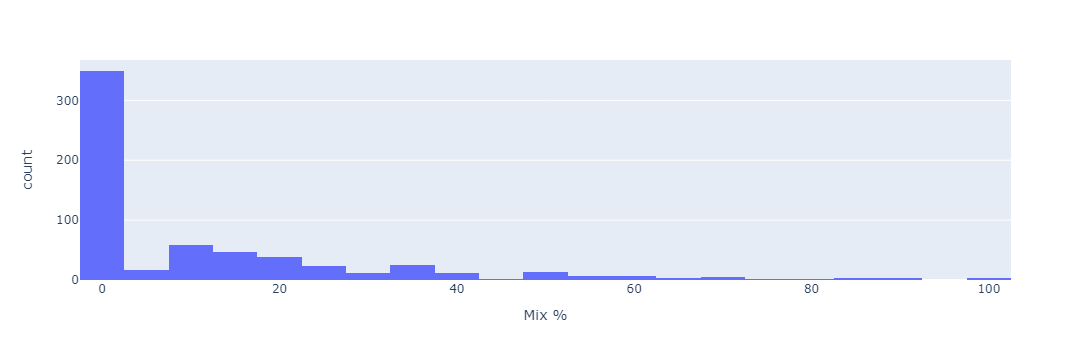

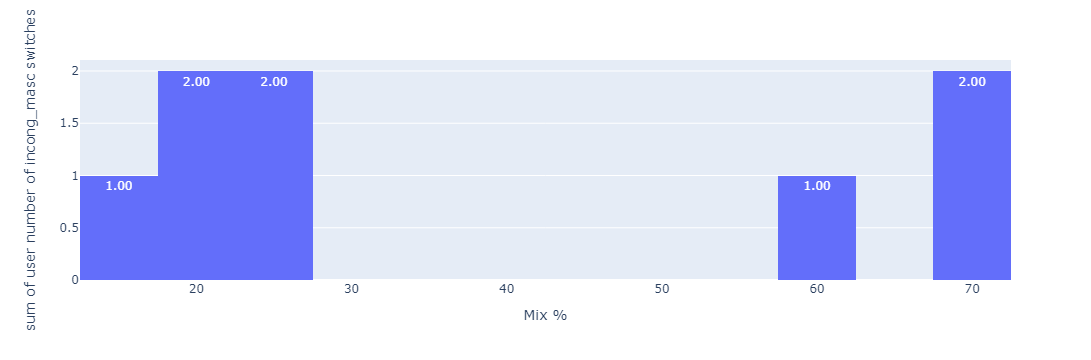

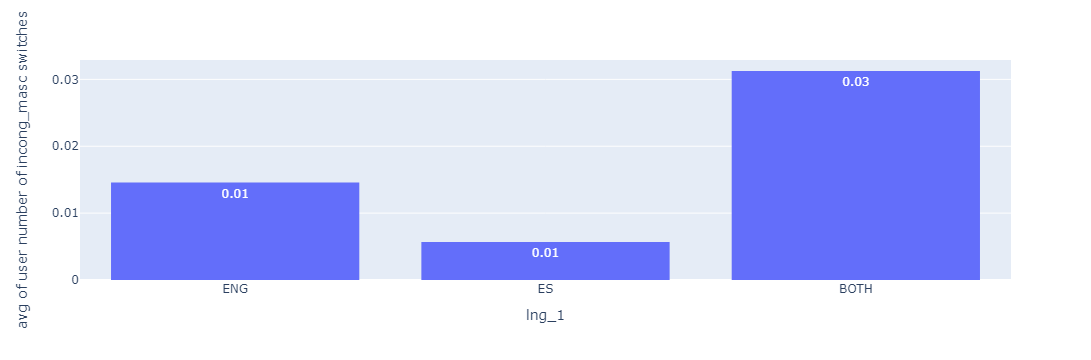

In [15]:
y = 'user number of incong_masc switches'
# y = 'user number of total ins switches'
# y = "user number of utterances with some ins switch"
# y = 'Mix %'
# y = 'Inter-Sentential CS %'


px.histogram(df_copy,  x='Mix %').show()

px.histogram(df_copy,
             y=y,
             x='Mix %',  #Q_enjoy_mix #Q_mix_often
             # color='experiment',
             text_auto='.2f',
             # histfunc='avg',
            ).update_xaxes(categoryorder="array",categoryarray=list(range(100))).show()

px.histogram(df_copy,
             y=y,
             x='lng_1',  #Q_enjoy_mix #Q_mix_often
             # color='experiment',
             text_auto='.2f',
             histfunc='avg',
            ).show()


In [16]:
df_copy['Enter your native language, or the language you are providing answers for, here:'].value_counts()

Enter your native language, or the language you are providing answers for, here:
English                 288
Spanish                 136
english                  92
spanish                  28
English                  20
English, Spanish         12
Spanish                   8
english                   8
Spanish and English.      4
English/Spanish           4
english and spanish       4
SPANISH/ENGLISH           4
spanish                   4
English Language          4
SPANISH, ENGLISH          4
Español                   4
Portuguese                4
Name: count, dtype: int64

In [17]:
df_copy['lng_2'].value_counts()

lng_2
ES      408
ENG     184
NONE     32
BOTH      4
Name: count, dtype: int64

In [18]:
df_copy['lng_1']

0       ENG
1       ENG
2       ENG
3       ENG
28      ENG
       ... 
1295    ENG
1296     ES
1297     ES
1298     ES
1299     ES
Name: lng_1, Length: 628, dtype: object

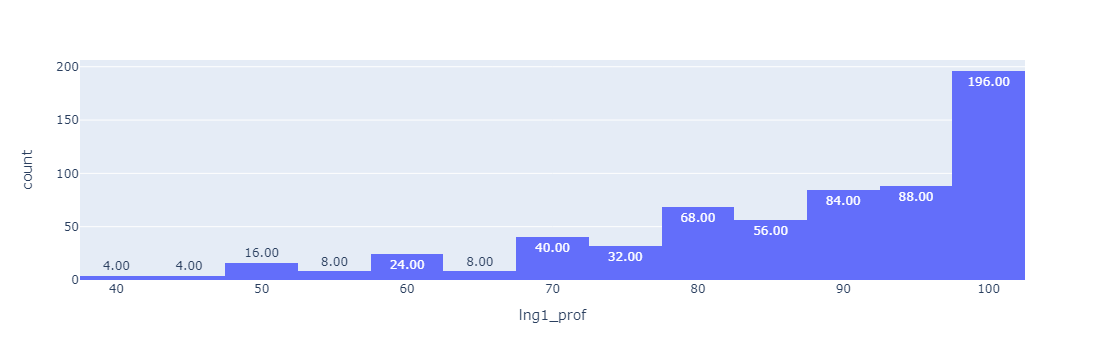

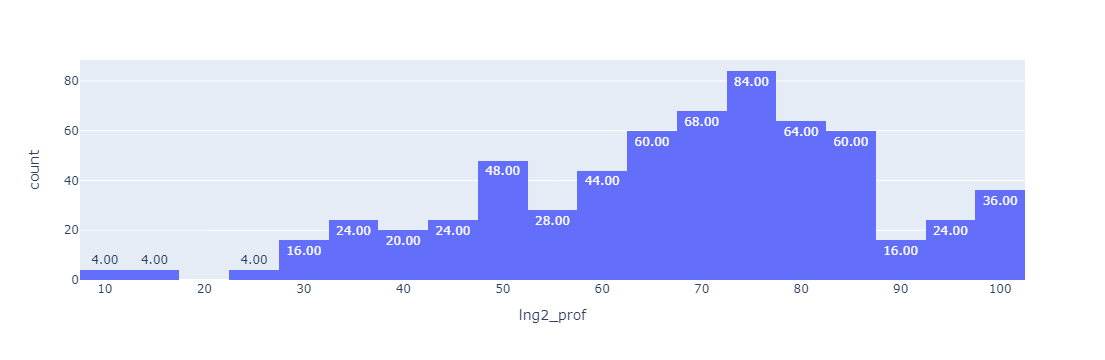

In [19]:
px.histogram(df_copy,
             # y='lng1_prof',
             x='lng1_prof',
             # color='experiment',
             text_auto='.2f',
             # histfunc='avg',
            ).show()

px.histogram(df_copy,
             # y='lng1_prof',
             x='lng2_prof',
             # color='experiment',
             text_auto='.2f',
             # histfunc='avg',
            ).show()


# px.scatter(df_copy,
#              y='eng_prof',
#              x='spa_prof',
#              # color='experiment',
#              # histfunc='avg',
#             ).show()





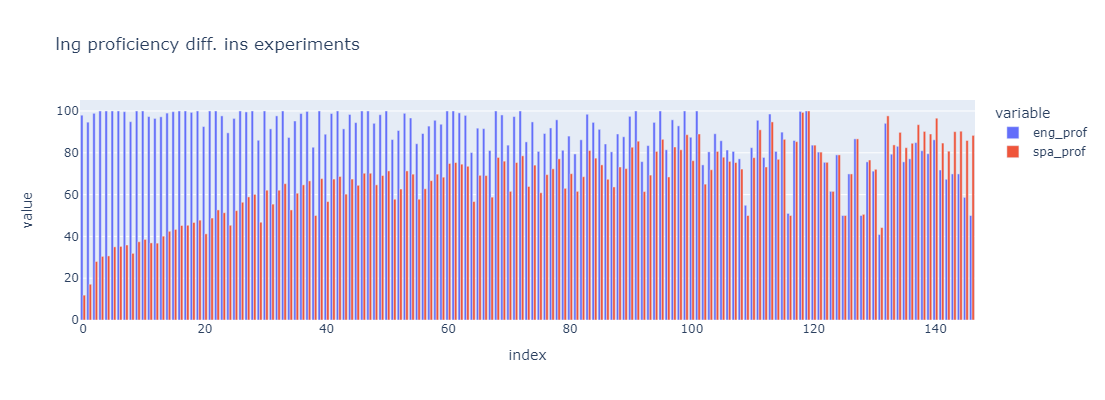

In [20]:
eng_prof = np.array(list(df_copy['eng_prof'])[0::4])
spa_prof = np.array(list(df_copy['spa_prof'])[0::4])
diff = eng_prof - spa_prof
# tmp_df['diff'] = tmp_df['eng_prof'] - tmp_df['spa_prof']

tmp_df = pd.DataFrame(
    {'eng_prof': eng_prof,
     'spa_prof': spa_prof,
     'diff': diff
    })

tmp_df = tmp_df.sort_values(by=['diff'], ascending=False)
tmp_df = tmp_df.dropna()
tmp_df.reset_index(drop=True, inplace=True)

fig = px.bar(tmp_df,
             # x='experiment',
             y=['eng_prof', 'spa_prof'],
             barmode = 'group',
             title=f"lng proficiency diff. {global_exp_} experiments",
             width=1100, height=400
            )

fig.show()


In [21]:
# px.bar(df_copy,
#              x='experiment',
#              color='lng_2',
# #                y='Q_enjoy',
#                barmode="group"
#             ).show()

# px.histogram(df_copy,
#              x='lng_2',
# #              y='Q_enjoy',
#              color='experiment',
#              text_auto='.2f',
#              histfunc='avg',
#              barmode="group",
#             ).show()
# # px.bar(df_copy,
# #              x='experiment',
# #              color='lng_2',
# #                barmode="group"
# #             ).show()

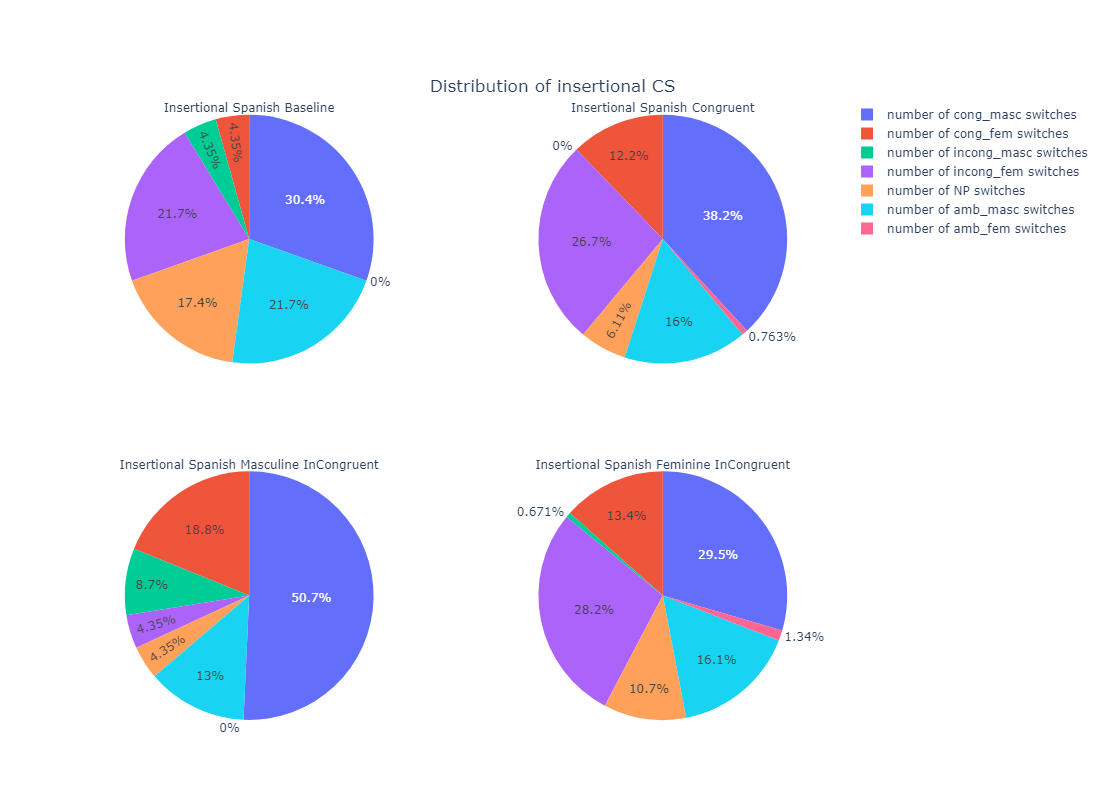

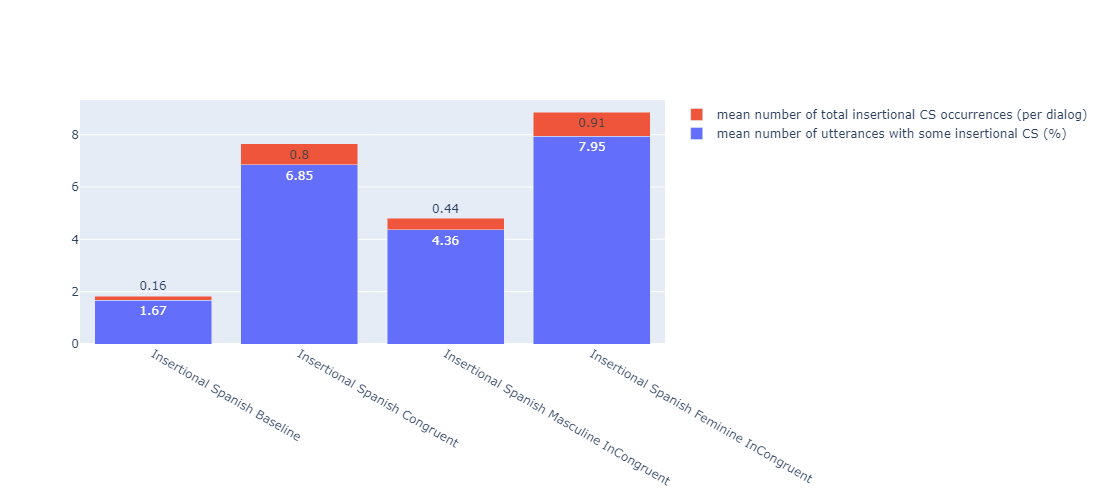

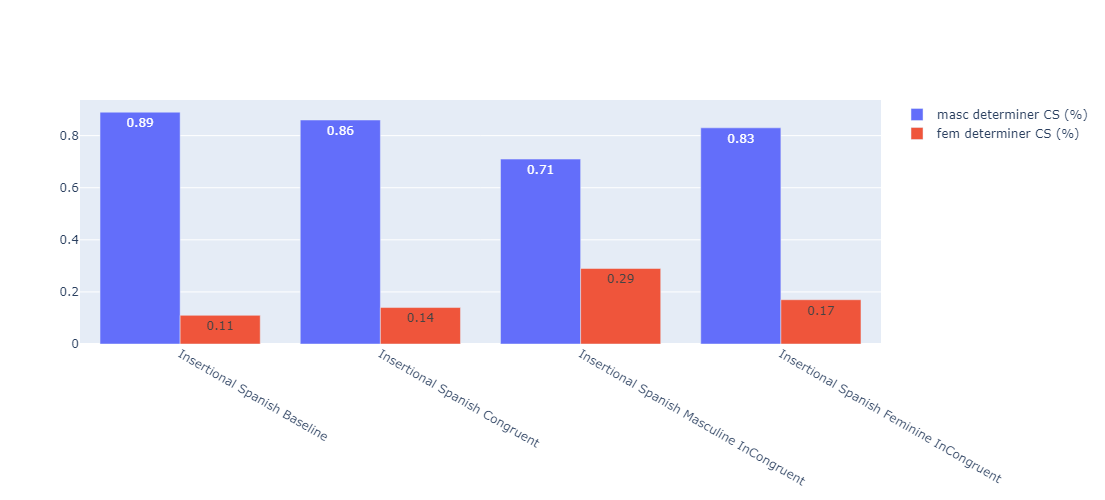

In [22]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math


def format_percentage(num: int) -> str:
    return round(num * 100, 2)

features=['user number of cong_masc switches',
          'user number of cong_fem switches',
          'user number of incong_masc switches', # incong 1
          'user number of incong_fem switches', # incong 2
          'user number of NP switches',
          'user number of amb_masc switches', 
          'user number of amb_fem switches']
pies=[]

mean_num_uter_w_cong_cs_normal_values = []
mean_num_of_total_cong_switch = []
masc_det = []
fem_det = []

for exp in experiments:
    exp_df = get_experiment_df([exp])
    exp_df = remove_rename_columns(exp_df)

    #bar plot
    mean_utters = np.mean(exp_df['user number of utterances'])
    mean_num_uter_w_cong_cs = np.mean(exp_df['user number of utterances with some ins switch'])
    mean_num_uter_w_cong_cs_normal_values.append(format_percentage(mean_num_uter_w_cong_cs / mean_utters))

    mean_num_of_total_cong_switch.append(round(np.mean(exp_df['user number of total ins switches']),2))

    total_det_cs = np.sum(exp_df['user number of masc det switches']) + np.sum(exp_df['user number of fem det switches'])
    
    masc_det.append(round(np.sum(exp_df['user number of masc det switches'])/total_det_cs,2))
    fem_det.append(round(np.sum(exp_df['user number of fem det switches'])/total_det_cs,2))

    # distribution of cong types
    means_ = {}
    for f in features:
        means_[f] = np.mean(exp_df[f]) / np.mean(exp_df['user number of total ins switches'])

    labels = list(means_.keys())
    labels = [l[5:] for l in labels]
    values = list(means_.values())
    pies.append(go.Pie(labels=labels,values=values, sort=False,title=exp))


rows = math.ceil(len(pies) /2)
specs = [[{"type": "domain"}, {"type": "domain"}]] * rows
opts = [(1,1), (1,2), (2,1), (2,2), (3,1)]
fig = make_subplots(
    rows=rows, cols=2,
    specs=specs,
)

for idx, p in enumerate(pies):
    row, col = opts[idx]
    fig.add_trace(p,row=row, col=col)

# fig.update_layout(height=800, width=800)
    fig.update_layout(
    width=900,
    height=800,
    title={
    'text': 'Distribution of insertional CS',
    'y':0.9,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Bar(x=experiments,
                    name='mean number of utterances with some insertional CS (%)',
                    y=mean_num_uter_w_cong_cs_normal_values,
                    text=mean_num_uter_w_cong_cs_normal_values))
fig.add_trace(go.Bar(x=experiments,
                    name='mean number of total insertional CS occurrences (per dialog)',
                    y=mean_num_of_total_cong_switch,
                    text=mean_num_of_total_cong_switch))
fig.update_layout(barmode='stack',width=1000,height=500)
fig.show()

fig = go.Figure()
fig.add_trace(go.Bar(x=experiments,
                    name='masc determiner CS (%)',
                    y=masc_det,
                    text=masc_det))
fig.add_trace(go.Bar(x=experiments,
                    name='fem determiner CS (%)',
                    y=fem_det,
                    text=fem_det))
fig.update_layout(width=1000,height=500)
fig.show()


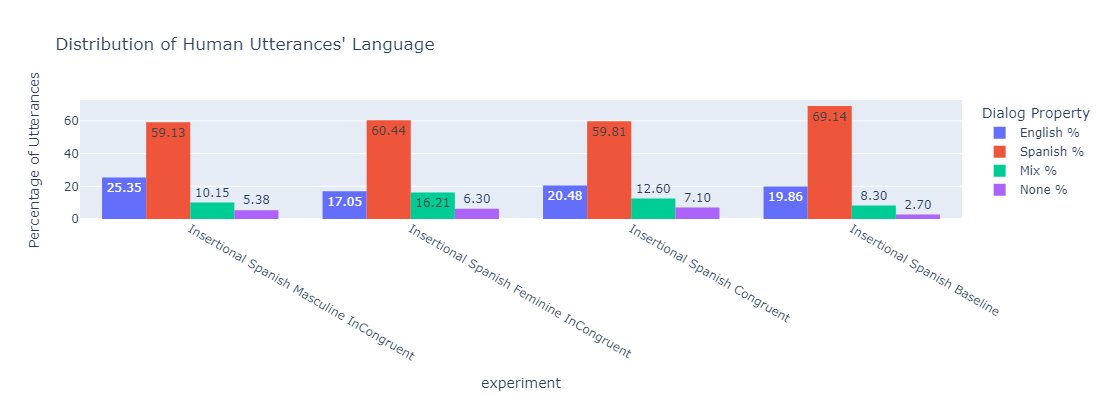

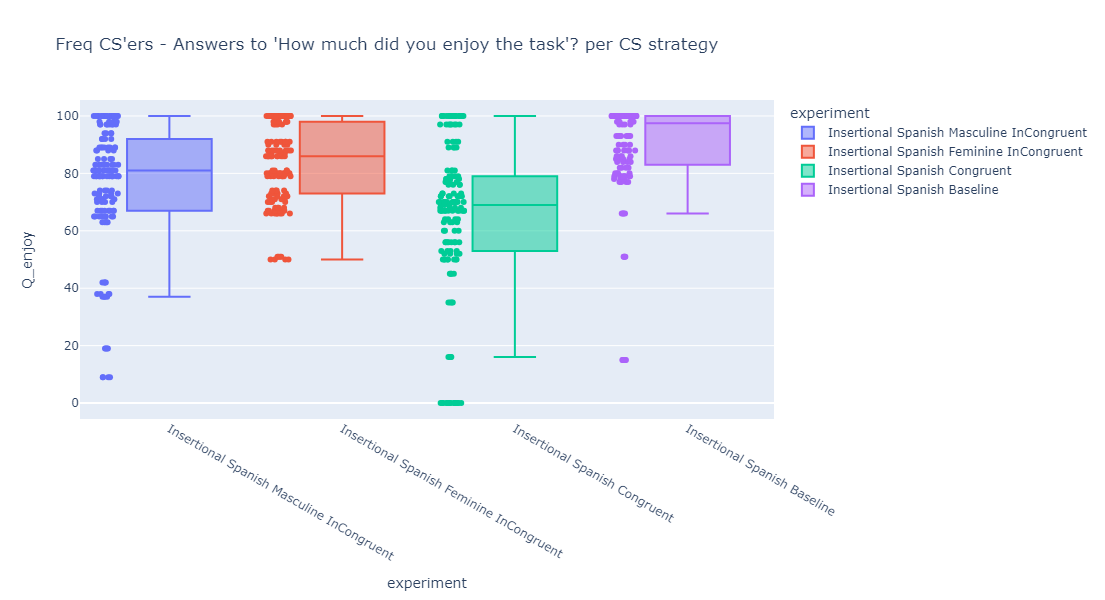

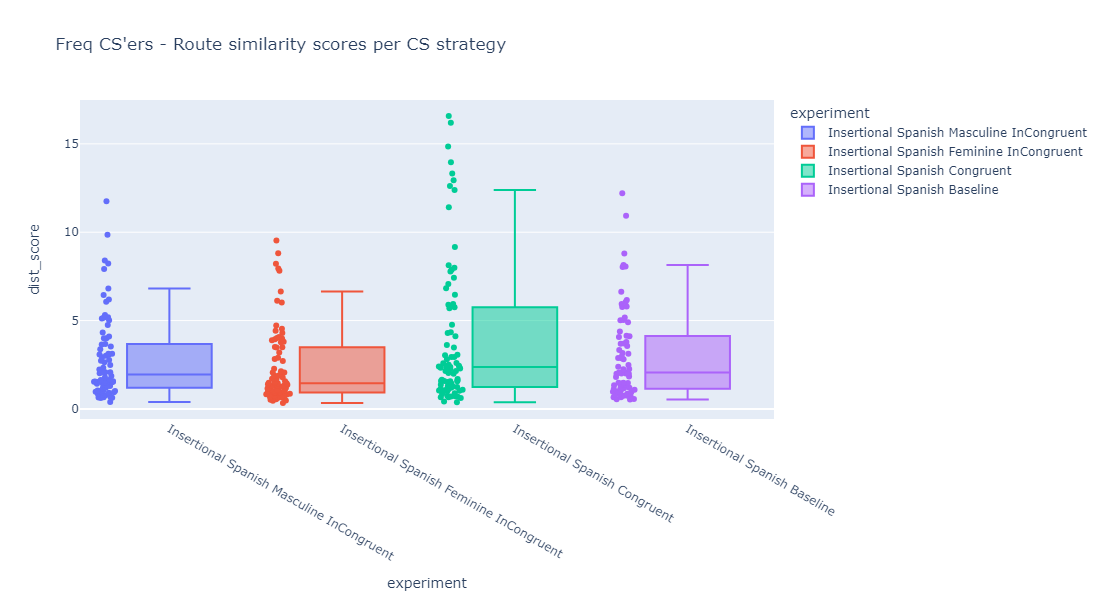

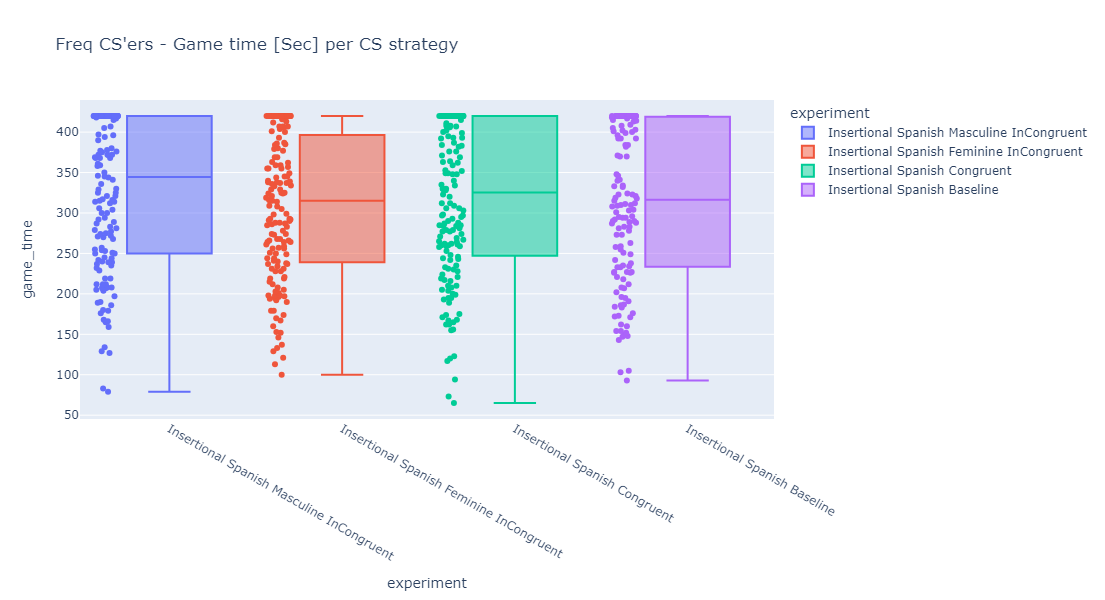

In [23]:
features=['English %', 'Spanish %', 'Mix %', 'None %'] # "Inter-Sentential CS %"]
fig = px.histogram(df_copy,
             x='experiment',
             y=features,
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
             width=1000, height=400,
             title="Distribution of Human Utterances' Language",
            )

fig.update_layout(
    yaxis_title="Percentage of Utterances",
    legend_title="Dialog Property",
)
fig.show()

# features=["Inter-Sentential CS %"]
# fig = px.histogram(df_copy,
#              x='experiment',
#              y=features,
#              text_auto='.2f',
#              histfunc='avg',
#              barmode="group",
#              title="Inter-Sentential CS %",
#             )
# fig.show()


# if global_exp_ == 'ins':
#     features=['Q_successful', 'Q_enjoy', 'Q_enjoy_mix', 'Q_mix_friends', 'Q_mix_often', 'Q_natural']
# else:
#     features=['Q_successful', 'Q_enjoy', 'Q_enjoy_mix', 'Q_mix_friends']
# px.histogram(df_copy,
#              x='experiment',
#              y=features,
#              text_auto='.2f',
#              histfunc='avg',
#              barmode="group",
#             ).show()

# fig = px.box(df_copy,
#              x='experiment',
#              y="Inter-Sentential CS %",
#              points="all",
#              color='experiment',
#              title="Inter-Sentential CS (%) metric per CS strategy",
#             ).show()

# px.histogram(df_copy,
#              x='experiment',
#              y=['% entrainment - all dialog', '% entrainment - on bot inter-sentential cs'],
#              text_auto='.2f',
#              histfunc='avg',
#              barmode="group",
#             ).show()


# fig = px.box(df_copy,
#              x='experiment',
#              y='% entrainment - on bot inter-sentential cs',
#              points="all",
#              color='experiment',
#              title="Entrainment metric (on bot inter-sentential cs) per CS strategy",
#             ).show()

# fig = px.box(df_copy,
#              x='experiment',
#              y='% entrainment - all dialog',
#              points="all",
#              color='experiment',
#              title="Entrainment (overall) metric per CS strategy",
#             ).show()

fig = px.box(df_copy,
             x='experiment',
             y='Q_enjoy',
             points="all",
             color='experiment',
             title="Freq CS'ers - Answers to 'How much did you enjoy the task'? per CS strategy",
             width=1000, height=600
            ).show()

fig = px.box(df_copy,
             x='experiment',
             y='dist_score',
             points="all",
             color='experiment',
             title="Freq CS'ers - Route similarity scores per CS strategy",
             width=1000, height=600
            ).show()

fig = px.box(df_copy,
             x='experiment',
             y='game_time',
             points="all",
             color='experiment',
             title="Freq CS'ers - Game time [Sec] per CS strategy",
             width=1000, height=600
            ).show()
